# Add Memory to Chatbot

In order to make your application chat back and forth with users, you need to store prior conversations and relevant context. LLMs are stateless and hence each time you prompt, a new response is generated. To provide historical information to the model, you need a memory system that can keep track of previous conversations and context.

A simple way to build a chatbot memory system is to store and reuse the history of all chat interactions between the user and the model. The state of this system can be stored as a list of messages, updated by appending recent messages after each turn, appeneded into the prompt by inserting the messages into the prompt.

In [4]:
from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI
# from langchain_ollama import ChatOllama
from langchain_mistralai import ChatMistralAI
import os

prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant. Answer all questions to the best 
        of your ability."""),
    ("placeholder", "{messages}"),
])

if 'MISTRAL_API_KEY' not in os.environ:
    raise ValueError('MISTRAL_API_KEY required to work with ChatMistralAI')

# model = ChatOpenAI()
# model = ChatOllama(model='gemma3:latest', temperature=0)
model = ChatMistralAI(
    model='mistral-small-latest',
    temperature=0
)

chain = prompt | model

response = chain.invoke({
    "messages": [
        ("human","""Translate this sentence from English to French: I love 
            programming."""),
        ("ai", "J'adore programmer."),
        ("human", "What did you just say?"),
    ],
})
response.content

'I translated the sentence "I love programming" from English to French as "J\'adore programmer."'

Some of the challenges with this approach to store interactions are below.
- You need to update memory after each interaction atomically.
- You'll have to store these memories in durable storage like RDBMs.
- You also have to control how many and which messages are stored for later use and how many of those are used for new interactions.
- You'll wan to inspect and modify state outside a call to an LLM.

## LangGraph Intro

LangGraph was designed to enable developers to implement multiactor, multistep, stateful cognitive architectures called graphs. 
Multiple LLMs or even in combination with web search, we can build complex systems. An application with multiple actors need a coordiantion layer to do these things.
- Define the actors involved and how they hand off work to each other (edges of that graph).
- Schedule execution of each actor at an appropriate time - in parallel if needed - with deterministic results.

When each actor hand off to another, you need to understand back-and-forth between multiple actors. You need to know what order it happens in, how many times each actor is called, etc. Communication across steps require tracking state otherwise when you call the LLM actor the second time, you will get the same result as the first time. It's helpful to pull this state out of each actors and have all actors collaborate on updating a single central state. With single state, you can 
- snapshot and store the central state during or after each computation
- pause and resume execution, which makes it easy to recover from errors.
- implement human-in-the-loop controls

Each graph is made up of below components.
- State: The data received from outside the application, modified and produced by the application while it's running
- Nodes: Each step is called a node. Nodes are Python functions which receive the current state as input and can return an updte to that state
- Edges: The connection between nodes. Edges determine the path taken from the first node to the last or they can be fixed or conditional.

LangGraph offers utilities to visualize these graphs and numerous features to debug their workings while developing them. These graphs can then be deployed to serve production workloads at scale. 

You can add LangGraph using `uv` with below command.

```shell
uv add langgraph
```

### Create StateGraph

First, create `StateGraph`.

For defining graph, first define the state of the graph. The state consists of the shape, schema of the graph state and a reducer functions which specify how to update the state. In this case, the state is a dictionary with single key `messages`. The `messages` key is annotated with `add_messages` reducer function. This function tells LangGraph to append new messages to the existing list.

State keys without an annotation will be overwritten by each update, storing the most recent value. You can also use your own reducer which receive two arguments:
1. current state
2. The next value being written to the state
and it returns the next state which is the result of merging the current state with the new value.


In [5]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` 
    # function in the annotation defines how this state should 
    # be updated (in this case, it appends new messages to the 
    # list, rather than replacing the previous messages)
	messages: Annotated[list, add_messages]

builder = StateGraph(State)

Every `node` you define will receive the current `State` as input and return a value that updates that state. Next, add `chatbot` node. Nodes represent units of work which are typically just functions.

In [6]:
# from langchain_ollama import ChatOllama

# model = ChatOllama(
#     model = 'gemma3:latest',
#     temperature=0.1
# )
from langchain_mistralai import ChatMistralAI

model = ChatMistralAI(
    model = 'mistral-small-latest',
    temperature=0.1
)

def chatbot(state: State):
    answer = model.invoke(state['messages'])
    return {'messages': [answer]}

# The first argument is the unique node name
# The second argument is the function or Runnable to run
builder.add_node("chatbot", chatbot)

This node receives current state, calls LLM and returns an update to the state containing the new message by the LLM. Finally, add the edges.

In [7]:
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

This tells the graph where to start its work each time you run it. This instructs the graph where it should exit (LangChain will stop execution once there's no more nodes to run). It compiles the graph into a runnable object with `invoke` and `stream` methods.

You can also draw a visual representation of the graph using below code.

```python
graph.get_graph().draw_mermaid_png()
```

You can run it graph with `stream()` method.

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

input = {"messages": [HumanMessage('hi!')]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='Hello! 😊 How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 5, 'total_tokens': 18, 'completion_tokens': 13}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop'}, id='run--1a6cd2d2-3891-4945-a58e-a267fdcfae9e-0', usage_metadata={'input_tokens': 5, 'output_tokens': 13, 'total_tokens': 18})]}}


The graph has input of the same shape as the defined `State` object.

## Adding Memory to StateGraph

LangGraph has built-in persistence. You will recompile your graph, attaching a checkpointer (which is a storage adapter for LangChain). LangChain ships with a base class that any user can subclass to create an adapter for their favorite database. LangChain also ships with several adapters maintained by LangChain.
- An in-memory adapter
- SQLite Adapter
- Postgres adapter

In [9]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

This returns a runnable objet with same methods, but now it stores the state at the end of each step, so every invocation after the first doesn't start from a blank state. Every time the graph is called, it starts by using the checkpointer to fetch the most recent saved state and combines the new input with the previous state.

In [10]:
thread1 = {"configurable": {"thread_id": "1"}}
result_1 = graph.invoke(
    { "messages": [HumanMessage("hi, my name is Jack!")] }, 
    thread1
)
result_2 = graph.invoke(
    { "messages": [HumanMessage("what is my name?")] }, 
    thread1
)

In LangChain, each interaction belongs to a particular history of interactions called threads. Threads are created automatically when first used. The threads allow LLM application to be used by multiple users with independent conversations which are never mixed up.

First time you call the `chatbot` node with single message, it returns another message and both of these are saved in the state. The second time you execute the graph on same thread, the `chatbot` node is called with three messages.

You can inspect and update the state directly.

In [11]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='c52cc6cc-61de-4187-9888-3f1a692b0634'), AIMessage(content='Hi Jack! Nice to meet you. 😊 How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 10, 'total_tokens': 29, 'completion_tokens': 19}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop'}, id='run--b7b42cb5-a0f3-4dc8-b707-6f30b16f54c3-0', usage_metadata={'input_tokens': 10, 'output_tokens': 19, 'total_tokens': 29}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='86d9411c-b81e-48e3-951b-f76e52d265d3'), AIMessage(content='Your name is **Jack**—that’s what you told me! 😊\n\n(Unless you’d like to change it or clarify anything, of course!)', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 36, 'total_tokens': 70, 'completion_tokens': 34}, 'model_name': '

You can update the state like this.

In [12]:
graph.update_state(thread1, {'messages': [HumanMessage("I like LLMs!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e5b2d-0d37-6560-8005-80a66adc0a06'}}

Above code added one message to the list of messages in the state.

In [13]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='hi, my name is Jack!', additional_kwargs={}, response_metadata={}, id='c52cc6cc-61de-4187-9888-3f1a692b0634'), AIMessage(content='Hi Jack! Nice to meet you. 😊 How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 10, 'total_tokens': 29, 'completion_tokens': 19}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop'}, id='run--b7b42cb5-a0f3-4dc8-b707-6f30b16f54c3-0', usage_metadata={'input_tokens': 10, 'output_tokens': 19, 'total_tokens': 29}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='86d9411c-b81e-48e3-951b-f76e52d265d3'), AIMessage(content='Your name is **Jack**—that’s what you told me! 😊\n\n(Unless you’d like to change it or clarify anything, of course!)', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 36, 'total_tokens': 70, 'completion_tokens': 34}, 'model_name': '

## Modifying Chat History

You can modify chat history in three ways: trimming, filtering and merging messages.

### 1. Trimming Messages

LLMs have limited context windows. The final prompt sent to the model shouldn't exceed the limit of context window. If you have long chat history and want to load them into prompt, you may need to trim messages. LangChain provides built-in `trim_messages` that includes various strategies to do this.

Below example retrieves the last `max_tokens` in the list of messages by setting a strategy to `"last"`.

In [19]:
from langchain_core.messages import SystemMessage, trim_messages
# from langchain_ollama import ChatOllama
from langchain_mistralai import ChatMistralAI

trimmer = trim_messages(
    max_tokens=25,
    strategy="last",
    # token_counter=ChatOllama(model="gemma3:latest"),
    token_counter=ChatMistralAI(model='mistral-small-latest'),
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="what's 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

The `strategy` controls whether to start from the beginning or the end of the list. The `token_counter` is an LLM which will be used to count tokens using tokenizer appropriate to the model. The parameter `start_on` ensures that we never remove an `AIMessage` without also removing a corresponding `HumanMessage` from the chat history.

### 2. Filtering Messages

LangChain's `filter_messages` makes it easy to filter the chat history by type, ID or name.

In [20]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    filter_messages,
)

messages = [
    SystemMessage("you are a good assistant", id="1"),
    HumanMessage("example input", id="2", name="example_user"),
    AIMessage("example output", id="3", name="example_assistant"),
    HumanMessage("real input", id="4", name="bob"),
    AIMessage("real output", id="5", name="alice"),
]

filter_messages(messages, include_types="human")

[HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4')]

You can see that this tends to keep `HumanMessage`. Below code, on the other hand, exclude users and IDs and include message types.

In [22]:
filter_messages(messages, exclude_names=["example_user", "example_assistant"])

filter_messages(
    messages, 
    include_types=[HumanMessage, AIMessage], 
    exclude_ids=["3"]
)

[HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'),
 HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4'),
 AIMessage(content='real output', additional_kwargs={}, response_metadata={}, name='alice', id='5')]

You could also use `filter_messages` as a declarative syntax.

In [23]:
model = ChatMistralAI(model='mistral-small-latest')
filter_ = filter_messages(exclude_names=['example_user', 'example_assistant'])
chain = filter_ | model

### 3. Merging Consecutive Messages

LangChain's `merge_message_runs` makes it easy to merge consecutive messages of the same type.

In [24]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    merge_message_runs,
)

messages = [
    SystemMessage("you're a good assistant."),
    SystemMessage("you always respond with a joke."),
    HumanMessage(
        [{"type": "text", "text": "i wonder why it's called langchain"}]
    ),
    HumanMessage("and who is harrison chasing anyway"),
    AIMessage(
        '''Well, I guess they thought "WordRope" and "SentenceString" just 
        didn\'t have the same ring to it!'''
    ),
    AIMessage("""Why, he's probably chasing after the last cup of coffee in the 
        office!"""),
]

merge_message_runs(messages)

[SystemMessage(content="you're a good assistant.\nyou always respond with a joke.", additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'text', 'text': "i wonder why it's called langchain"}, 'and who is harrison chasing anyway'], additional_kwargs={}, response_metadata={}),
 AIMessage(content='Well, I guess they thought "WordRope" and "SentenceString" just \n        didn\'t have the same ring to it!\nWhy, he\'s probably chasing after the last cup of coffee in the \n        office!', additional_kwargs={}, response_metadata={})]

In [25]:
model = ChatMistralAI(model='mistral-small-latest')
merger = merge_message_runs()
chain = merger | model

## LangChain Application Architectures

There are various application architectures incorporated for LLM applications.
1. LLM call: This is making single LLM call to achieve specific task.
2. Chain: Use multiple LLM calls in sequence to execute chain of actions.
3. Router: In this case, LLM decides what next step to take.

### 1. LLM call

Start by creating a `StateGraph` and you add a node to call LLM.

In [19]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
# from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI


# model = ChatOpenAI()
model = ChatMistralAI(model='mistral-medium-latest')

class State(TypedDict):
    # Messages have the type "list". The `add_messages` 
    # function in the annotation defines how this state should 
    # be updated (in this case, it appends new messages to the 
    # list, rather than replacing the previous messages)
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

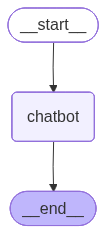

In [3]:
from IPython.display import Image, display

# Assuming 'graph' is your compiled LangGraph object
png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

Next, you can run it with `stream()` method.

In [7]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

input = {"messages": [HumanMessage('hi!')]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content="Hi there! 😊 How can I help you today? Whether you have a question, need advice, or just want to chat—I'm here for it! 🚀\n\n(Also, if you're into emojis, here's a virtual high-five: ✋)", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 5, 'total_tokens': 64, 'completion_tokens': 59}, 'model_name': 'mistral-medium-latest', 'model': 'mistral-medium-latest', 'finish_reason': 'stop'}, id='run--6c456c72-3caa-4e1a-9cf2-49855f0313c4-0', usage_metadata={'input_tokens': 5, 'output_tokens': 59, 'total_tokens': 64})]}}


The input to the graph was in the same shape as the `Shape` object defined earlier. 
This is the simplest possible LLM architecture with single LLM call. You might see this in:
- AI-powered summarizer and translate
- Simple SQL query generation could be powered by single LLM call.

### 2. Chain

This is where you make multiple LLM calls in predefined sequence. Some also call this *Flow Engineering*. An example would like follows.
1. LLM call to generate SQL query from natural language query provided by the user and a description of the database contents.
2. Another LLM call to write an explanation of the query for non-technical user for the query generated in the previous call.
3. Execute the query against the database which returns a table with rows and columns.
4. Use LLM call to summarize the query results into a textual answer for the original question.

In [20]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
# from langchain_openai import ChatOpenAI
# from langchain_mistralai import ChatMistralAI
from langchain_ollama import ChatOllama

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

# useful to generate SQL query
# model_low_temp = ChatOpenAI(temperature=0.1)
# model_low_temp = ChatMistralAI(model='mistral-medium-latest', temperature=0.1)
model_low_temp = ChatOllama(model='gemma3:latest', temperature=0.1)

# useful to generate natural language outputs
# model_high_temp = ChatOpenAI(temperature=0.7)
# model_high_temp = ChatMistralAI(model='mistral-medium-latest', temperature=0.3)
model_high_temp = ChatOllama(model='gemma3:latest', temperature=0.4)

class State(TypedDict):
    # to track conversation history
    messages: Annotated[list, add_messages]
    # input
    user_query: str
    # output
    sql_query: str
    sql_explanation: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    sql_query: str
    sql_explanation: str

generate_prompt = SystemMessage(
    """You are a helpful data analyst who generates SQL queries for users based 
    on their questions. Provide only SQL query as output."""
)

def generate_sql(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "sql_query": res.content,
        # update conversation history
        "messages": [user_message, res],
    }

explain_prompt = SystemMessage(
    "You are a helpful data analyst who explains SQL queries to users."
)

def explain_sql(state: State) -> State:
    messages = [
        explain_prompt,
        # contains user's query and SQL query from prev step
        *state["messages"],
    ]
    res = model_high_temp.invoke(messages)
    return {
        "sql_explanation": res.content,
        # update conversation history
        "messages": res,
    }

builder = StateGraph(State, input=Input, output=Output)
builder.add_node("generate_sql", generate_sql)
builder.add_node("explain_sql", explain_sql)
builder.add_edge(START, "generate_sql")
builder.add_edge("generate_sql", "explain_sql")
builder.add_edge("explain_sql", END)

graph = builder.compile()

/var/folders/gb/6k7kx0813nj31c19df8s6xs40000gp/T/ipykernel_83334/3913710264.py:69: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)
/var/folders/gb/6k7kx0813nj31c19df8s6xs40000gp/T/ipykernel_83334/3913710264.py:69: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)


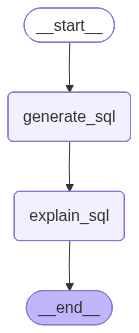

In [21]:
from IPython.display import Image, display

# Assuming 'graph' is your compiled LangGraph object
png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [24]:
# For debugging set debug=True
from langchain.globals import set_debug
set_debug(False)

graph.invoke({
  "user_query": "What is the total sales for each product?"
})

{'sql_query': '```sql\nSELECT product_id, SUM(price * quantity) AS total_sales\nFROM order_items\nGROUP BY product_id;\n```',
 'sql_explanation': "\n\n**Explanation:**\n\nLet's break down this SQL query step-by-step:\n\n1. **`SELECT product_id, SUM(price * quantity) AS total_sales`**:\n   - `product_id`:  This selects the unique identifier for each product. We want to see the total sales *for each* product.\n   - `SUM(price * quantity)`: This is the core of the calculation.  It multiplies the `price` (the price of one unit of the product) by the `quantity` (the number of units sold in an order) for each row in the `order_items` table. The `SUM()` function then adds up all those individual product sales amounts.\n   - `AS total_sales`: This gives a more descriptive name to the calculated column.  Instead of just seeing `SUM(price * quantity)`, the column will be labeled `total_sales` in the results.\n\n2. **`FROM order_items`**:\n   - This specifies that we're pulling data from the `ord

You can monitor different LLM calls by setting debug to `True`. Here, you used separate input and output schemas when creating `StateGraph`. This lets you control which parts of the state are accepted as output. The remaining state keys are used by graph internally.

### 3. Router

This architecture assigns more autonomy to LLMs about the next step to take. The Chain architecture always executes a static sequence of steps, the router architecture is where LLM choose between predefined steps. In the past, you needed a classifier to correctly classify the route it should take whereas now you can use LLMs to create this flow.
1. LLM call to pick which of the available indexes to use, given the user-supplied query and developer supplied description of indexes.
2. A retrieval step queries chosen index for most relevant documents based on user query.
3. Next, LLM call to generate an answer based on these relevant documents.

In [28]:
from typing import Annotated, Literal, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
# from langchain_openai import OpenAIEmbeddings
from langchain_ollama import OllamaEmbeddings
# from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

# embeddings = OpenAIEmbeddings()
embeddings = OllamaEmbeddings(
    model='embeddinggemma'
)

# useful to generate SQL query
# model_low_temp = ChatOpenAI(temperature=0.1)
model_low_temp = ChatMistralAI(model='mistral-large-latest', temperature=0.1)

# useful to generate natural language outputs
# model_high_temp = ChatOpenAI(temperature=0.7)
model_high_temp = ChatMistralAI(model='mistral-large-latest', temperature=0.4)

class State(TypedDict):
    # to track conversation history
    messages: Annotated[list, add_messages]
    # input
    user_query: str
    # output
    domain: Literal["records", "insurance"]
    documents: list[Document]
    answer: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    documents: list[Document]
    answer: str

# refer to Chapter 2 on how to fill a vector store with documents
medical_records_store = InMemoryVectorStore.from_documents([], embeddings)
medical_records_retriever = medical_records_store.as_retriever()

insurance_faqs_store = InMemoryVectorStore.from_documents([], embeddings)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()

router_prompt = SystemMessage(
    """You need to decide which domain to route the user query to. You have two 
        domains to choose from:
          - records: contains medical records of the patient, such as 
          diagnosis, treatment, and prescriptions.
          - insurance: contains frequently asked questions about insurance 
          policies, claims, and coverage.

Output only the domain name."""
)

def router_node(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [router_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "domain": res.content,
        # update conversation history
        "messages": [user_message, res],
    }

def pick_retriever(
    state: State,
) -> Literal["retrieve_medical_records", "retrieve_insurance_faqs"]:
    if state["domain"] == "records":
        return "retrieve_medical_records"
    else:
        return "retrieve_insurance_faqs"

def retrieve_medical_records(state: State) -> State:
    documents = medical_records_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

def retrieve_insurance_faqs(state: State) -> State:
    documents = insurance_faqs_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

medical_records_prompt = SystemMessage(
    """You are a helpful medical chatbot who answers questions based on the 
        patient's medical records, such as diagnosis, treatment, and 
        prescriptions."""
)

insurance_faqs_prompt = SystemMessage(
    """You are a helpful medical insurance chatbot who answers frequently asked 
        questions about insurance policies, claims, and coverage."""
)

def generate_answer(state: State) -> State:
    if state["domain"] == "records":
        prompt = medical_records_prompt
    else:
        prompt = insurance_faqs_prompt
    messages = [
        prompt,
        *state["messages"],
        HumanMessage(f"Documents: {state['documents']}"),
    ]
    res = model_high_temp.invoke(messages)
    return {
        "answer": res.content,
        # update conversation history
        "messages": res,
    }

builder = StateGraph(State, input=Input, output=Output)
builder.add_node("router", router_node)
builder.add_node("retrieve_medical_records", retrieve_medical_records)
builder.add_node("retrieve_insurance_faqs", retrieve_insurance_faqs)
builder.add_node("generate_answer", generate_answer)
builder.add_edge(START, "router")
builder.add_conditional_edges("router", pick_retriever)
builder.add_edge("retrieve_medical_records", "generate_answer")
builder.add_edge("retrieve_insurance_faqs", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

/var/folders/gb/6k7kx0813nj31c19df8s6xs40000gp/T/ipykernel_83334/3884933853.py:120: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)
/var/folders/gb/6k7kx0813nj31c19df8s6xs40000gp/T/ipykernel_83334/3884933853.py:120: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)


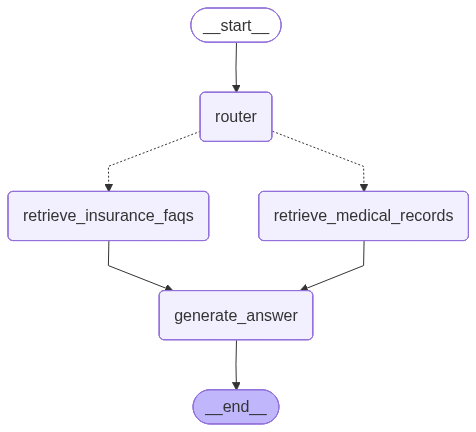

In [29]:
from IPython.display import Image, display

# Assuming 'graph' is your compiled LangGraph object
png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

This is very useful because based on user query, you can route the request to different LLM agents. You first visit the router node and finish by visiting `generate_answer` node. The decision of which node to pick next is decided by the conditional edge in function `pick_retriever` which maps the `domain` to one of the two nodes `retrieve_medical_records` or `retrieve_insurance_faqs`.

In [30]:
input = {
    "user_query": "Am I covered for COVID-19 treatment?"
}
for c in graph.stream(input):
    print(c)

{'router': {'domain': 'insurance', 'messages': [HumanMessage(content='Am I covered for COVID-19 treatment?', additional_kwargs={}, response_metadata={}, id='2c9aab65-660d-4835-8422-6c1504e2da5f'), AIMessage(content='insurance', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 88, 'total_tokens': 91, 'completion_tokens': 3}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run--dcc61eb4-ea7e-45a4-b8f8-fef17d78c482-0', usage_metadata={'input_tokens': 88, 'output_tokens': 3, 'total_tokens': 91})]}}
{'retrieve_insurance_faqs': {'documents': []}}
{'generate_answer': {'answer': 'Here’s a general answer about COVID-19 coverage under most health insurance policies in the U.S. (since I don’t have access to your specific documents):\n\n### **COVID-19 Treatment Coverage**\nMost health insurance plans (including employer-sponsored, ACA Marketplace, Medicare, and Medicaid) cover **medically necessary COVID-19 treatment**, 